# Multimodal LLMs - Medium Tasks

Intermediate multimodal tasks. Batch processing, similarity matrices, multi-turn conversations.

**Topics:**
- Multi-image similarity comparison
- Image search with text queries
- Multi-turn visual conversations
- Custom image preprocessing

## Setup

Run all cells in this section.

### [Optional] - Installing Packages on Google Colab

If you are viewing this notebook on Google Colab, uncomment and run the following code to install dependencies.

**Note**: Use a GPU for this notebook. In Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4.

In [1]:
# %%capture
# !pip install matplotlib transformers datasets accelerate sentence-transformers pillow scikit-learn

### Import Libraries

In [2]:
from urllib.request import urlopen
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from sklearn.metrics.pairwise import cosine_similarity


### Load Models

In [3]:
# CLIP
model_id = "openai/clip-vit-base-patch32"
print("Loading CLIP...")

clip_tok = CLIPTokenizerFast.from_pretrained(model_id)
clip_proc = CLIPProcessor.from_pretrained(model_id)
clip_model = CLIPModel.from_pretrained(model_id)

print("CLIP loaded")

Loading CLIP...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP loaded


In [4]:
# BLIP-2
print("Loading BLIP-2...")

blip_proc = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24"  # Choose specific model because of: https://huggingface.co/Salesforce/blip2-opt-2.7b/discussions/39
)

blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24",
    torch_dtype=torch.float16,
)

# Fix for missing bos_token_id and image_token_index in model config, as suggested in Hugging Face discussions
if blip_model.config.text_config.bos_token_id is None:
    blip_model.config.text_config.bos_token_id = blip_proc.tokenizer.bos_token_id
if blip_model.config.image_token_index is None:
    blip_model.config.image_token_index = blip_proc.tokenizer.convert_tokens_to_ids('<image>')

dev = "cuda" if torch.cuda.is_available() else "cpu"
blip_model.to(dev)

print(f"BLIP-2 loaded on {dev}")

Loading BLIP-2...


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

BLIP-2 loaded on cuda


### Load Images

In [5]:
# URLs
puppy = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
cat = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"

paths = [puppy, cat, car]
imgs = [Image.open(urlopen(p)).convert("RGBA") for p in paths]

print(f"Loaded {len(imgs)} images")

Loaded 3 images


## Medium Tasks

More complex multimodal operations.

### Task 1: Batch Image Embeddings

Process multiple images at once. More efficient than one-by-one.

**Goal**: Embed all images in a batch, store embeddings.

In [6]:
# Embed all images
img_embs = []

for img in imgs:
    proc = clip_proc(images=img, return_tensors='pt')['pixel_values']
    emb = clip_model.get_image_features(proc)
    img_embs.append(emb.detach().cpu().numpy()[0])

img_embs = np.array(img_embs)

print(f"Embedded {len(img_embs)} images")
print(f"Shape: {img_embs.shape}")

Embedded 3 images
Shape: (3, 512)


In [7]:
# Check embeddings are different
print("First 3 values of each:")
for i, emb in enumerate(img_embs):
    print(f"Image {i}: {emb[:3]}")

First 3 values of each:
Image 0: [-0.06882298  0.32204086  0.04269803]
Image 1: [ 0.24555475 -0.00499079  0.32134053]
Image 2: [ 0.04830285 -0.19246414 -0.736603  ]


**Questions:**

1. How would you save these embeddings to disk?
2. What if you had 10,000 images?
3. Could you batch process instead of looping?

### Task 2: Similarity Matrix

Compare all images to all captions. See which pairs match best.

**Goal**: Create NxM matrix of image-caption similarities.

In [8]:
# Captions
caps = [
    "a puppy playing in the snow",
    "a pixelated image of a cute cat",
    "A supercar on the road with the sunset in the background"
]

print("Captions:")
for i, c in enumerate(caps, 1):
    print(f"{i}. {c}")

Captions:
1. a puppy playing in the snow
2. a pixelated image of a cute cat
3. A supercar on the road with the sunset in the background


In [9]:
# Embed captions
txt_embs = []

for cap in caps:
    inp = clip_tok(cap, return_tensors="pt")
    emb = clip_model.get_text_features(**inp)
    txt_embs.append(emb.detach().cpu().numpy()[0])

txt_embs = np.array(txt_embs)

print(f"\nEmbedded {len(txt_embs)} captions")


Embedded 3 captions


In [10]:
# Compute similarity matrix
sim_mat = cosine_similarity(img_embs, txt_embs)

print(f"Similarity matrix shape: {sim_mat.shape}")
print(f"(rows=images, cols=captions)\n")
print(sim_mat)

Similarity matrix shape: (3, 3)
(rows=images, cols=captions)

[[0.33149624 0.18632853 0.10844273]
 [0.14878327 0.34630102 0.09465347]
 [0.07622198 0.12599239 0.309761  ]]


In [11]:
# Which caption matches each image?
print("\nBest matches:")
for i in range(len(imgs)):
    best_idx = np.argmax(sim_mat[i])
    sc = sim_mat[i][best_idx]
    print(f"Image {i} -> Caption {best_idx}: {caps[best_idx][:40]}... ({sc:.3f})")


Best matches:
Image 0 -> Caption 0: a puppy playing in the snow... (0.331)
Image 1 -> Caption 1: a pixelated image of a cute cat... (0.346)
Image 2 -> Caption 2: A supercar on the road with the sunset i... (0.310)


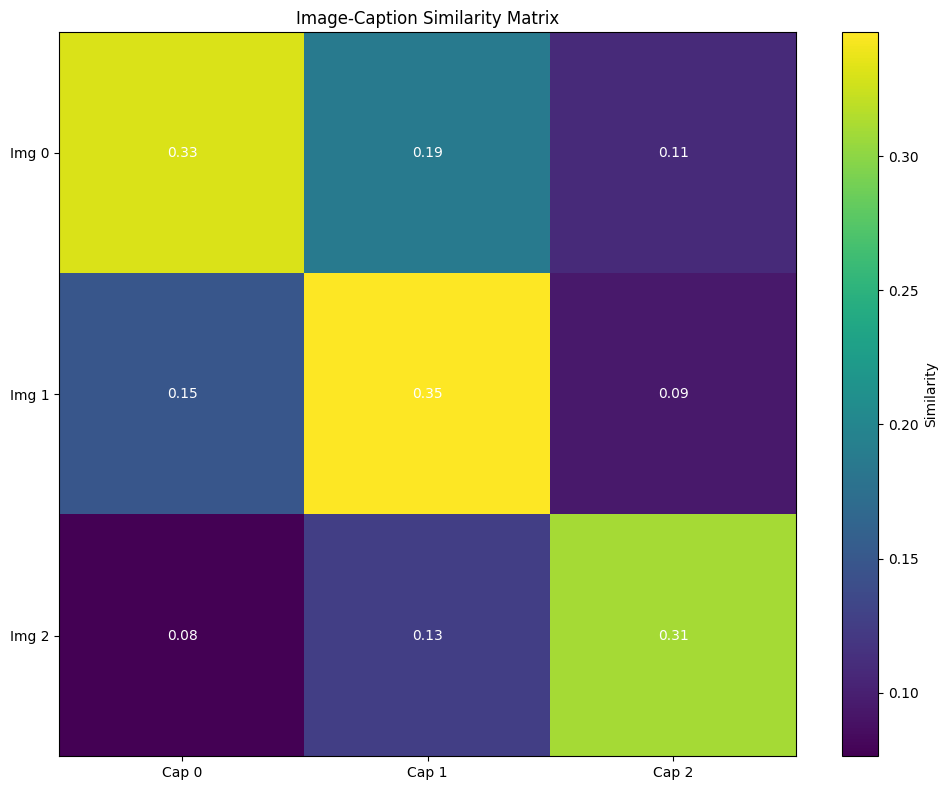

In [12]:
# Visualize matrix
plt.figure(figsize=(10, 8))
plt.imshow(sim_mat, cmap='viridis', aspect='auto')

plt.yticks(range(len(caps)), [f"Img {i}" for i in range(len(imgs))])
plt.xticks(range(len(caps)), [f"Cap {i}" for i in range(len(caps))])

plt.colorbar(label="Similarity")
plt.title("Image-Caption Similarity Matrix")

for i in range(sim_mat.shape[0]):
    for j in range(sim_mat.shape[1]):
        plt.text(j, i, f"{sim_mat[i, j]:.2f}",
                ha="center", va="center", color="white")

plt.tight_layout()
plt.show()

**Questions:**

1. Do diagonal elements have highest scores?
2. Try shuffled captions - does it still work?
3. What if captions are in different languages?

### Task 3: Multi-Turn Visual Conversation

Chat with BLIP-2 about an image. Keep conversation history.

**Goal**: Have a back-and-forth Q&A about an image.

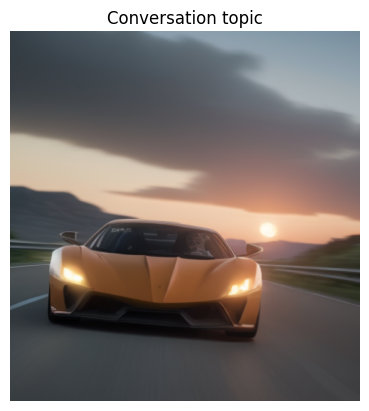

In [20]:
# Load image for conversation
img = Image.open(urlopen(car)).convert("RGB")

plt.imshow(img)
plt.axis('off')
plt.title("Conversation topic")
plt.show()

In [21]:
# Conversation memory
mem = []

def ask(question, max_tok=30):
    """Ask BLIP-2 a question about the image"""

    # Build prompt with history
    if not mem:
        prompt = f"Question: {question} Answer:"
    else:
        hist = " ".join([f"Question: {q} Answer: {a}." for q, a in mem])
        prompt = f"{hist} Question: {question} Answer:"

    # Generate
    inp = blip_proc(img, text=prompt, return_tensors="pt")
    inp = inp.to(dev, torch.float16)

    gen_ids = blip_model.generate(**inp, max_new_tokens=max_tok)
    ans = blip_proc.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

    # Update memory
    mem.append((question, ans))

    return ans

print("Ready to chat")

Ready to chat


In [22]:
# First question
q1 = "What do you see in this image?"
a1 = ask(q1)

print(f"Q: {q1}")
print(f"A: {a1}")

Q: What do you see in this image?
A: Question: What do you see in this image? Answer: A lot of things.


In [23]:
# Follow-up question
q2 = "What time of day is it?"
a2 = ask(q2)

print(f"Q: {q2}")
print(f"A: {a2}")

Q: What time of day is it?
A: Question: What do you see in this image? Answer: Question: What do you see in this image? Answer: A lot of things.. Question: What time of day is it? Answer: Question: What time of day is it? Answer: Question: What time of day is it? Answer: Question: What time of day is it


In [24]:
# Another follow-up
q3 = "Is anyone driving it?"
a3 = ask(q3)

print(f"Q: {q3}")
print(f"A: {a3}")

Q: Is anyone driving it?
A: Question: What do you see in this image? Answer: Question: What do you see in this image? Answer: A lot of things.. Question: What time of day is it? Answer: Question: What do you see in this image? Answer: Question: What do you see in this image? Answer: A lot of things.. Question: What time of day is it? Answer: Question: What time of day is it? Answer: Question: What time of day is it? Answer: Question: What time of day is it. Question: Is anyone driving it? Answer: Question: Is anyone driving it? Answer: Question: Is anyone driving it? Answer: Question: Is anyone driving it? Answer: Question: Is


In [25]:
# Check conversation history
print("\nFull conversation:")
for i, (q, a) in enumerate(mem, 1):
    print(f"\n{i}. Q: {q}")
    print(f"   A: {a}")


Full conversation:

1. Q: What do you see in this image?
   A: Question: What do you see in this image? Answer: A lot of things.

2. Q: What time of day is it?
   A: Question: What do you see in this image? Answer: Question: What do you see in this image? Answer: A lot of things.. Question: What time of day is it? Answer: Question: What time of day is it? Answer: Question: What time of day is it? Answer: Question: What time of day is it

3. Q: Is anyone driving it?
   A: Question: What do you see in this image? Answer: Question: What do you see in this image? Answer: A lot of things.. Question: What time of day is it? Answer: Question: What do you see in this image? Answer: Question: What do you see in this image? Answer: A lot of things.. Question: What time of day is it? Answer: Question: What time of day is it? Answer: Question: What time of day is it? Answer: Question: What time of day is it. Question: Is anyone driving it? Answer: Question: Is anyone driving it? Answer: Question:

**Questions:**

1. Does the model remember earlier answers?
2. Try asking contradictory questions - what happens?
3. What if conversation gets very long?

### Task 5: Custom Image Preprocessing

See how BLIP-2 preprocesses images. Understand the pipeline.

**Goal**: Manually preprocess an image, inspect intermediate steps.

In [26]:
# Load a wide image
img = Image.open(urlopen(car)).convert("RGB")

print(f"Original size: {img.size}")
print(f"Original mode: {img.mode}")

Original size: (492, 520)
Original mode: RGB


In [27]:
# Preprocess
inp = blip_proc(img, return_tensors="pt").to(dev, torch.float16)

pix_vals = inp['pixel_values']
print(f"\nProcessed shape: {pix_vals.shape}")
print(f"(batch, channels, height, width)")


Processed shape: torch.Size([1, 3, 224, 224])
(batch, channels, height, width)


In [28]:
# Extract and visualize
from sklearn.preprocessing import MinMaxScaler

proc_img = pix_vals[0].detach().cpu().numpy()

# Rearrange dims: (3, 224, 224) -> (224, 224, 3)
proc_img = np.einsum('ijk->kji', proc_img)
proc_img = np.einsum('ijk->jik', proc_img)

print(f"Rearranged shape: {proc_img.shape}")

Rearranged shape: (224, 224, 3)


In [29]:
# Scale to 0-255 for display
scaler = MinMaxScaler(feature_range=(0, 255))

flat = proc_img.reshape(-1, proc_img.shape[-1])
scaled = scaler.fit_transform(flat)
scaled = scaled.reshape(proc_img.shape)
scaled = scaled.astype(np.uint8)

print(f"Scaled to RGB range")

Scaled to RGB range


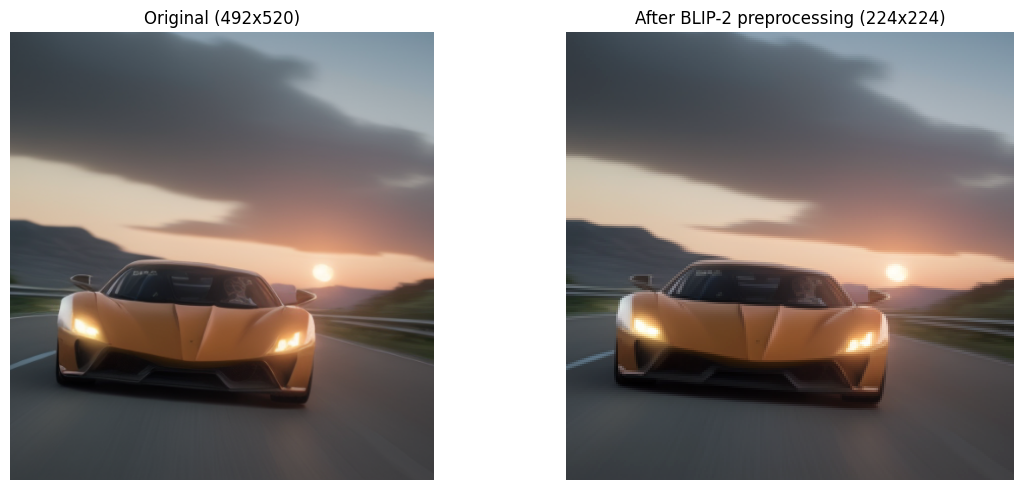

In [30]:
# Display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(img)
ax1.set_title(f"Original ({img.size[0]}x{img.size[1]})")
ax1.axis('off')

ax2.imshow(Image.fromarray(scaled))
ax2.set_title("After BLIP-2 preprocessing (224x224)")
ax2.axis('off')

plt.tight_layout()
plt.show()

In [31]:
# Check if aspect ratio preserved
orig_ratio = img.size[0] / img.size[1]
new_ratio = 224 / 224

print(f"Original aspect ratio: {orig_ratio:.2f}")
print(f"New aspect ratio: {new_ratio:.2f}")
print(f"Image was {'stretched' if orig_ratio != new_ratio else 'preserved'}")

Original aspect ratio: 0.95
New aspect ratio: 1.00
Image was stretched


**Questions:**

1. Why does BLIP-2 resize to 224x224?
2. What happens to very wide/tall images?
3. Could you preprocess differently for better results?

### Task 5: Comparing CLIP vs BLIP-2

Different models, different strengths. Compare their outputs.

**Goal**: Use both models on same image, see differences.

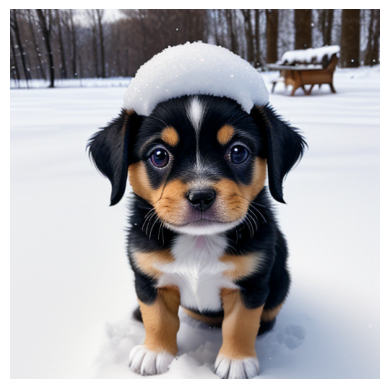

In [32]:
# Test image
img = Image.open(urlopen(puppy)).convert("RGB")

plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
# CLIP: classify image
classes = [
    "a photo of a dog in snow",
    "a photo of a cat",
    "a photo of a beach",
    "a photo of a car"
]

# Embed image
proc = clip_proc(images=img, return_tensors='pt')['pixel_values']
img_emb = clip_model.get_image_features(proc)
img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
img_np = img_emb.detach().cpu().numpy()

# Embed classes
scores = []
for cls in classes:
    inp = clip_tok(cls, return_tensors="pt")
    emb = clip_model.get_text_features(**inp)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    emb_np = emb.detach().cpu().numpy()
    sc = img_np @ emb_np.T
    scores.append(sc[0][0])

clip_pred = classes[np.argmax(scores)]

print("CLIP classification:")
print(f"Prediction: {clip_pred}")
print(f"Confidence: {max(scores):.3f}")

CLIP classification:
Prediction: a photo of a dog in snow
Confidence: 0.311


In [34]:
# BLIP-2: generate caption
inp = blip_proc(img, return_tensors="pt").to(dev, torch.float16)
gen_ids = blip_model.generate(**inp, max_new_tokens=20)
blip_cap = blip_proc.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

print("\nBLIP-2 caption:")
print(blip_cap)


BLIP-2 caption:
a puppy wearing a snow hat in the snow


In [35]:
# Compare
print("\nComparison:")
print(f"CLIP: Classifies into predefined categories")
print(f"  -> {clip_pred}")
print(f"\nBLIP-2: Generates free-form description")
print(f"  -> {blip_cap}")


Comparison:
CLIP: Classifies into predefined categories
  -> a photo of a dog in snow

BLIP-2: Generates free-form description
  -> a puppy wearing a snow hat in the snow


**Questions:**

1. Which is more useful for your use case?
2. Could you combine both models?
3. What are the tradeoffs (speed, accuracy, flexibility)?